<a href="https://colab.research.google.com/github/tushargupta123/deep-learning-practice/blob/main/Functional_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# For multiple outputs with single input

In [1]:
from keras.models import Model
from keras.layers import *

In [2]:
x = Input(shape=(3,))

In [3]:
hidden1 = Dense(128,activation='relu')(x)   # it is getting input from x
hidden2 = Dense(64,activation='relu')(hidden1)   # it is getting input from hidden1

output1 = Dense(1,activation='linear')(hidden2)
output2 = Dense(1,activation='sigmoid')(hidden2)

In [4]:
model = Model(inputs = x,outputs = [output1,output2])

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  512       ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 64)                   8256      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 1)                    65        ['dense_1[0][0]']             
                                                                                              

In [7]:
from keras.utils import plot_model

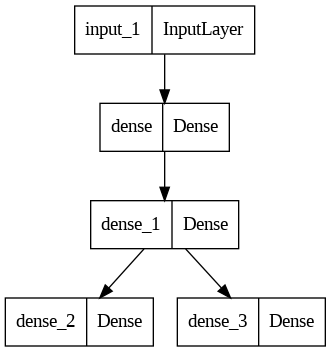

In [8]:
plot_model(model)

# for multiple inputs with single output

In [9]:
inputA = Input(shape=(32,))
inputB = Input(shape=(128,))

In [10]:
# for first input creating different branch
x = Dense(8,activation='relu')(inputA)
x1 = Dense(4,activation='relu')(x)

In [11]:
# for second input creating different branch
y = Dense(64,activation='relu')(inputB)
y1 = Dense(32,activation='relu')(y)
y2 = Dense(4,activation='relu')(y1)

In [12]:
# combine the outputs of both branches
combined = concatenate([x1,y2])

In [13]:
# apply FC layer and then a regression prediction on the combined outputs
z = Dense(2,activation='relu')(combined)
z1 = Dense(1,activation='linear')(z)

In [14]:
model = Model(inputs=[inputA,inputB],outputs=z1)

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 dense_6 (Dense)             (None, 64)                   8256      ['input_3[0][0]']             
                                                                                                  
 dense_4 (Dense)             (None, 8)                    264       ['input_2[0][0]']             
                                                                                            

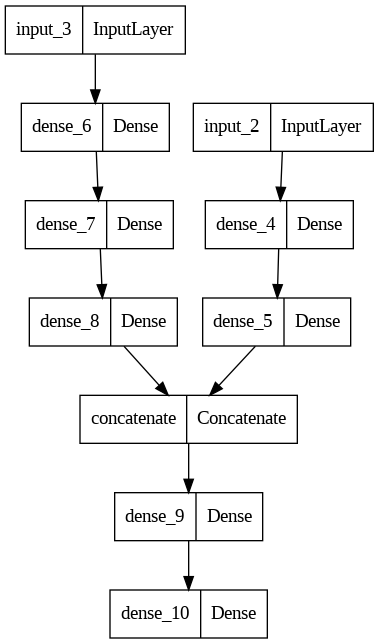

In [16]:
plot_model(model)

# AGE GENDER MULTI FUNCTIONAL NEURAL NETWORK

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d jangedoo/utkface-new

 99% 327M/331M [00:05<00:00, 24.2MB/s]
100% 331M/331M [00:05<00:00, 68.5MB/s]


In [4]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip",'r')
zip.extractall("/content")
zip.close()

In [7]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [5]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [8]:
age = []
gender = []
img_path = []
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [10]:
len(age)

23708

In [11]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [12]:
df.shape

(23708, 3)

In [13]:
df.head()

,age,gender,img
0,26,1,26_1_3_20170119193105762.jpg.chip.jpg
1,35,0,35_0_0_20170116204131804.jpg.chip.jpg
2,36,0,36_0_0_20170117135459790.jpg.chip.jpg
3,26,1,26_1_3_20170104215719454.jpg.chip.jpg
4,4,0,4_0_0_20170110213033450.jpg.chip.jpg


In [21]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [23]:
# data augumentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                  class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [26]:
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

In [27]:
resnet = ResNet50(include_top=False,input_shape=(200,200,3))

94765736/94765736 [==============================] - 1s 0us/step


In [28]:
resnet.trainable = False    # using transfer learning feature extraction
output = resnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512,activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [31]:
model = Model(inputs=resnet.input,outputs=[output1,output2])

In [33]:
model.compile(optimizer='adam',
              loss={'age':'mae','gender':'binary_crossentropy'},  # using different loss for different type of feature
              metrics={'age':'mae','gender':'accuracy'},
              loss_weights={'age':1,'gender':99})   # giving more weight to gender in overall loss calculations

In [34]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

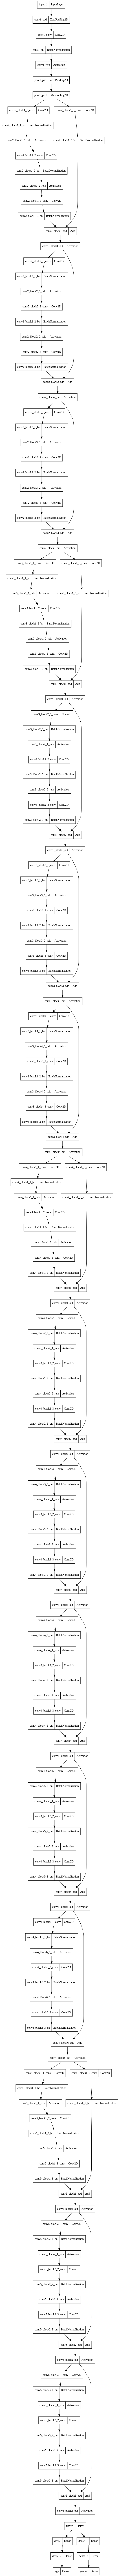

In [35]:
from keras.utils import plot_model
plot_model(model)

In [36]:
model.fit(train_generator,batch_size=32,epochs=10,validation_data=test_generator)

Epoch 1/10
625/625 [==============================] - 282s 425ms/step - loss: 104.3231 - age_loss: 15.4844 - gender_loss: 0.8974 - age_mae: 15.4844 - gender_accuracy: 0.5087 - val_loss: 83.3431 - val_age_loss: 14.8232 - val_gender_loss: 0.6921 - val_age_mae: 14.8232 - val_gender_accuracy: 0.5345
Epoch 2/10
625/625 [==============================] - 253s 404ms/step - loss: 84.3254 - age_loss: 15.0634 - gender_loss: 0.6996 - age_mae: 15.0634 - gender_accuracy: 0.5189 - val_loss: 83.1723 - val_age_loss: 14.7523 - val_gender_loss: 0.6911 - val_age_mae: 14.7523 - val_gender_accuracy: 0.5345
Epoch 3/10
625/625 [==============================] - 253s 404ms/step - loss: 83.9833 - age_loss: 14.9887 - gender_loss: 0.6969 - age_mae: 14.9887 - gender_accuracy: 0.5201 - val_loss: 82.9314 - val_age_loss: 14.5367 - val_gender_loss: 0.6909 - val_age_mae: 14.5367 - val_gender_accuracy: 0.5345
Epoch 4/10
625/625 [==============================] - 256s 410ms/step - loss: 83.6633 - age_loss: 14.8850 - gen